In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys  

sys.path.insert(0, '../models')
from singlelocusmodelextended import SingleLocusModelExt
modelext = SingleLocusModelExt(k=1)

panel_label_kw = dict(size=22)#, weight='bold')
star_kw = dict(marker='*', c='w', s=60)
blue,yellow,green,red,pink,brown,pink2,grey,yellow2,blue2 = sns.color_palette("colorblind", 10)
sns.color_palette("colorblind", 10)
genotype_colors = [yellow,blue,grey,pink,green,red]
genotype_labels = ['$2n$','$2n+1$','$2n+1^*$',r'$2n^*_A$',r'$2n^*_M$',r'$2n^*_A+2n^*_M$']

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Posterior $F_A$

In [2]:
post_sam = np.load('../../results/posterior_predictions/posterior_samples.npz', allow_pickle=True)['arr_0']
F_A = np.load('../../results/posterior_predictions/F_A-data.npz', allow_pickle=True)['arr_0']

In [3]:
mean_FA = np.mean(F_A)
perc_FA = np.percentile(F_A,(2.5, 97.5))
mean_FA, perc_FA

(0.16729464236904282, array([0.01540451, 0.36984928]))

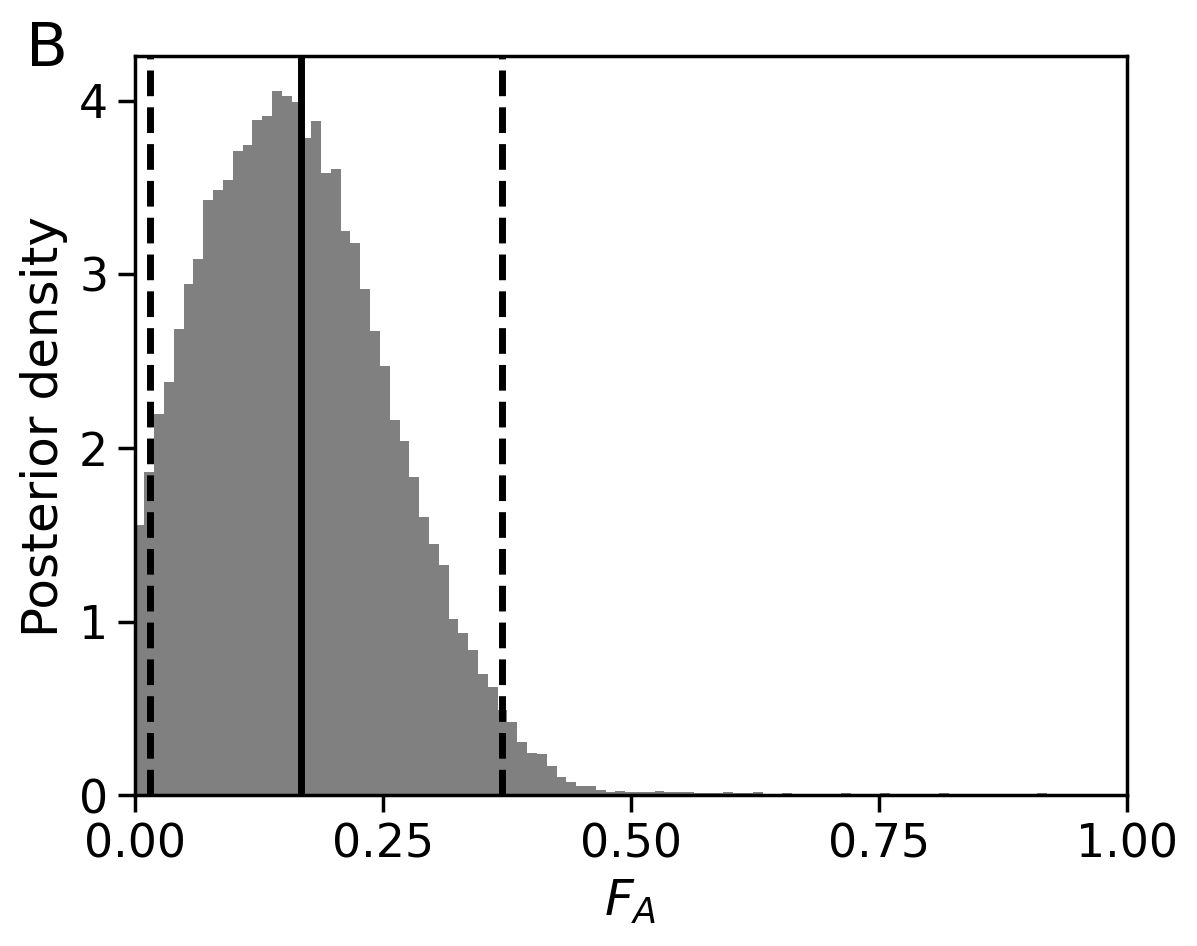

In [5]:
fig, ax = plt.subplots()
ax.hist(F_A, 100, density=True,color='grey')
ax.axvline(x=mean_FA,color='k')
ax.axvline(x=perc_FA[0],color='k',ls='--')
ax.axvline(x=perc_FA[1],color='k',ls='--')
ax.set_xlim([0,1])
panel_label = ax.text(-.11, 4.2, 'B',  **panel_label_kw)
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
xlabel = ax.set_xlabel("$F_A$")
ax.set_ylabel('Posterior density')

bbox = dict(bbox_inches='tight', bbox_extra_artists=[xlabel, panel_label])
# fig.savefig('../../figures/F_A_posterior.pdf', **bbox);

In [6]:
aneu_dom = F_A>.5
sum(aneu_dom), sum(aneu_dom)/len(F_A), len(F_A) #absolute number of cases where F_A is greater than 0.5, its fraction of the whole

(489, 0.00489, 100000)

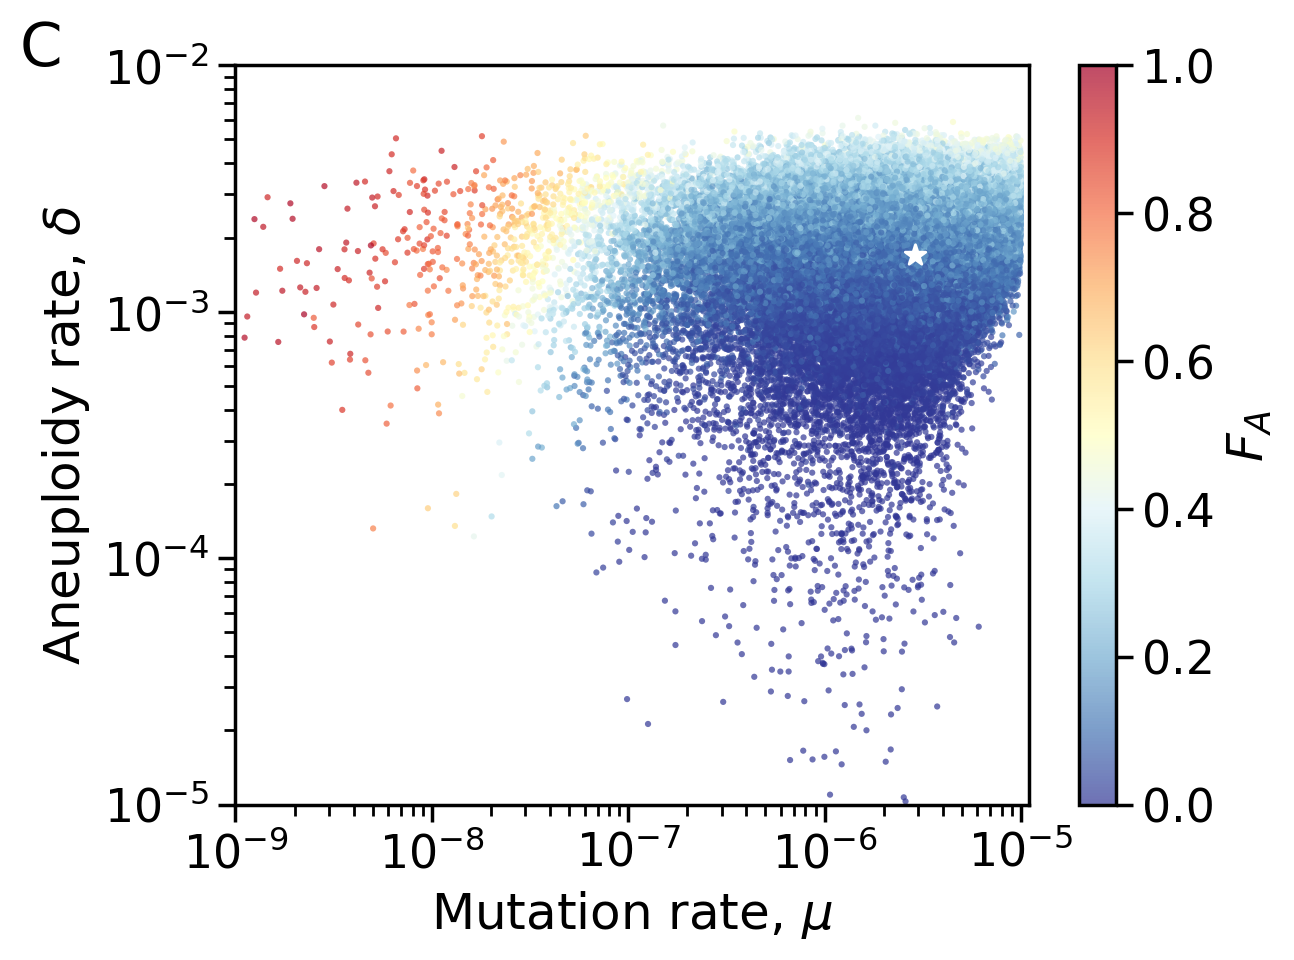

In [7]:
fig, ax = plt.subplots()

im = ax.scatter(post_sam[:,1],post_sam[:,2], c=F_A, cmap="RdYlBu_r", vmin=0, vmax=1, ec=None, alpha=.7, s=5, rasterized=True)
plt.colorbar(im, ax=ax, label='$F_A$')
ax.scatter(2.9e-6,1.7e-3, **star_kw)
ax.set_xscale('log')
ax.set_yscale('log')
xlabel = ax.set_xlabel('Mutation rate, $\mu$')
ax.set_ylabel('Aneuploidy rate, $\delta$')
ax.set_xlim([1e-9,1.1e-5])
ax.set_ylim([1e-5,1e-2])
panel_label = ax.text(8e-11, .01, 'C', **panel_label_kw)

bbox = dict(bbox_inches='tight', bbox_extra_artists=[xlabel, panel_label])
# fig.savefig('../../figures/F_A_mu_delta.pdf', **bbox);

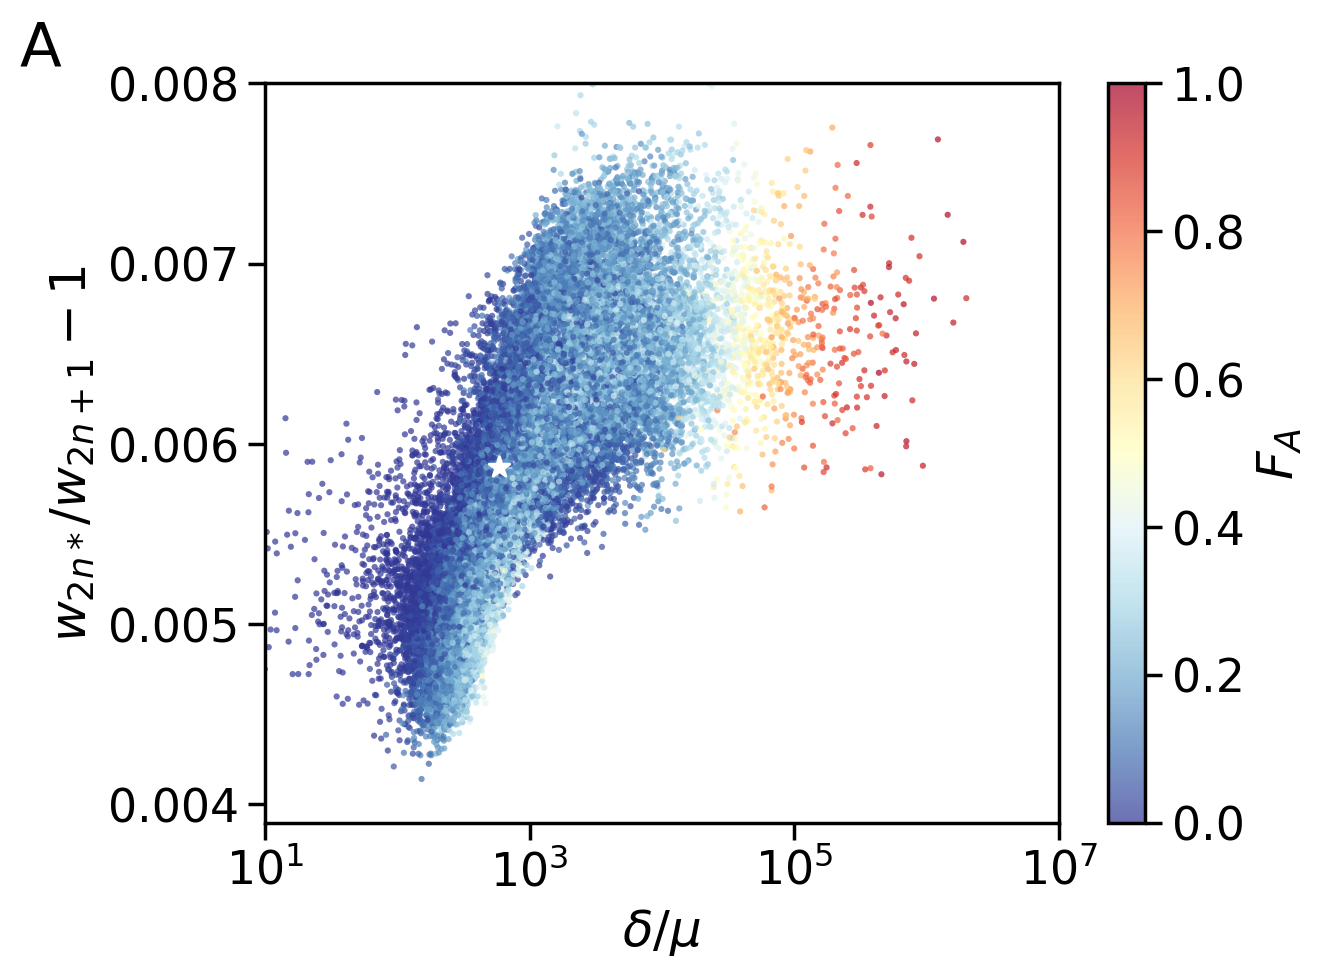

In [8]:
fig, ax = plt.subplots()

im = ax.scatter(post_sam[:,2]/post_sam[:,1],post_sam[:,5]/post_sam[:,3]-1, c=F_A, 
                cmap="RdYlBu_r", vmin=0, vmax=1, ec=None, alpha=.7, s=5, rasterized=True)
plt.colorbar(im, ax=ax, label='$F_A$')
ax.scatter(1.7e-3/2.9e-6,1.028/1.022-1, **star_kw)
ax.set_xscale('log')
xlabel = ax.set_xlabel('$\delta/\mu$')
ax.set_ylabel('$w_{2n*}/w_{2n+1}-1$')
ax.set_xlim([10,1e7])
ax.set_ylim([.0039,.008])
panel_label = panel_label = ax.text(0.14, 0.0081, 'A', **panel_label_kw)

bbox = dict(bbox_inches='tight', bbox_extra_artists=[xlabel, panel_label])
fig.savefig('../../figures/F_A_delta-mu-ratio_1.pdf', **bbox)

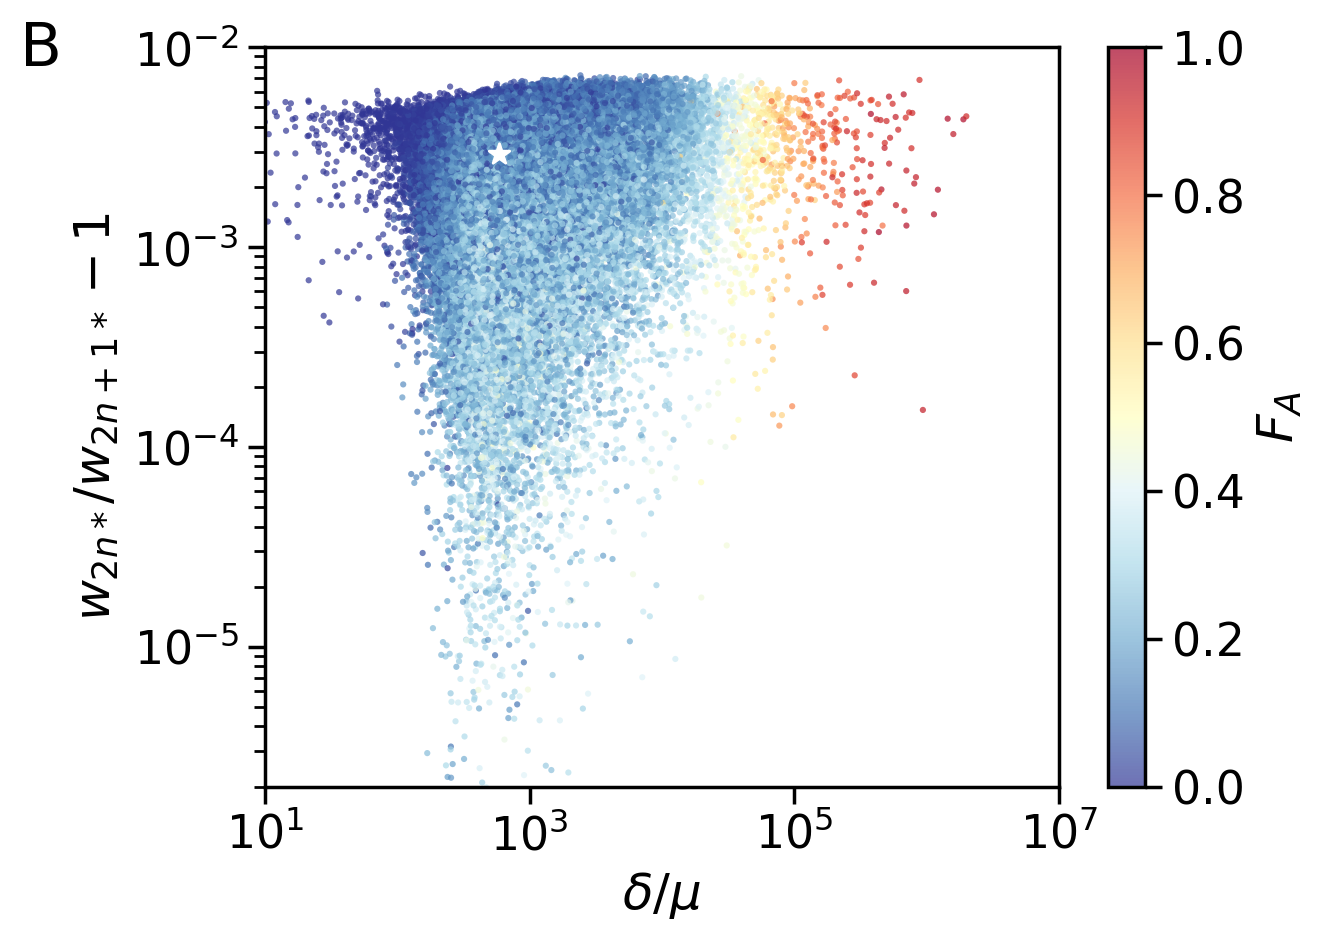

In [9]:
fig, ax = plt.subplots()

im = ax.scatter(post_sam[:,2]/post_sam[:,1],post_sam[:,5]/post_sam[:,4]-1, c=F_A, 
                cmap="RdYlBu_r", vmin=0, vmax=1, ec=None, alpha=.7, s=5, rasterized=True)
plt.colorbar(im, ax=ax, label='$F_A$')
ax.scatter(1.7e-3/2.9e-6,1.028/1.025-1, **star_kw)
ax.set_xscale('log')
ax.set_yscale('log')
xlabel = ax.set_xlabel('$\delta/\mu$')
ax.set_ylabel('$w_{2n*}/w_{2n+1*}-1$')
ax.set_xlim([10,1e7])
ax.set_ylim([2e-6,1e-2])
panel_label = panel_label = ax.text(0.14, 0.0081, 'B', **panel_label_kw)

bbox = dict(bbox_inches='tight', bbox_extra_artists=[xlabel, panel_label])
fig.savefig('../../figures/F_A_delta-mu-ratio_2.pdf', **bbox)

# MAP frequency dynamics

In [50]:
μ, δ, w1, w2, w3 = 2.942e-6, 1.722e-3, 1.022, 1.025, 1.028
N = int(6.425e6)
Mt = np.diag(np.repeat(0.,5))
Mt[0][1] = δ
# Mt[1][0] = δ
Mt[1][2] = μ
# Mt[2][1] = μ
Mt[2][3] = δ 
# Mt[3][2] = δ 
Mt[0][4] = μ
# Mt[4][0] = μ
Mt = Mt.transpose() 
np.fill_diagonal(Mt,0) #neutralling side effect
np.fill_diagonal(Mt,1-Mt.sum(axis=0)) #side effect
Δw = 0
w = [1., w1+Δw, w2+Δw, w3+Δw, w3+Δw]
S = np.diag(w)
E = Mt @ S
tmax = 2500
p = np.zeros((tmax, 5), dtype=float)
p[0, 0] = 1.0

In [51]:
for t in range(1, tmax):
    p[t] = E @ p[t-1]
    p[t] /= p[t].sum()

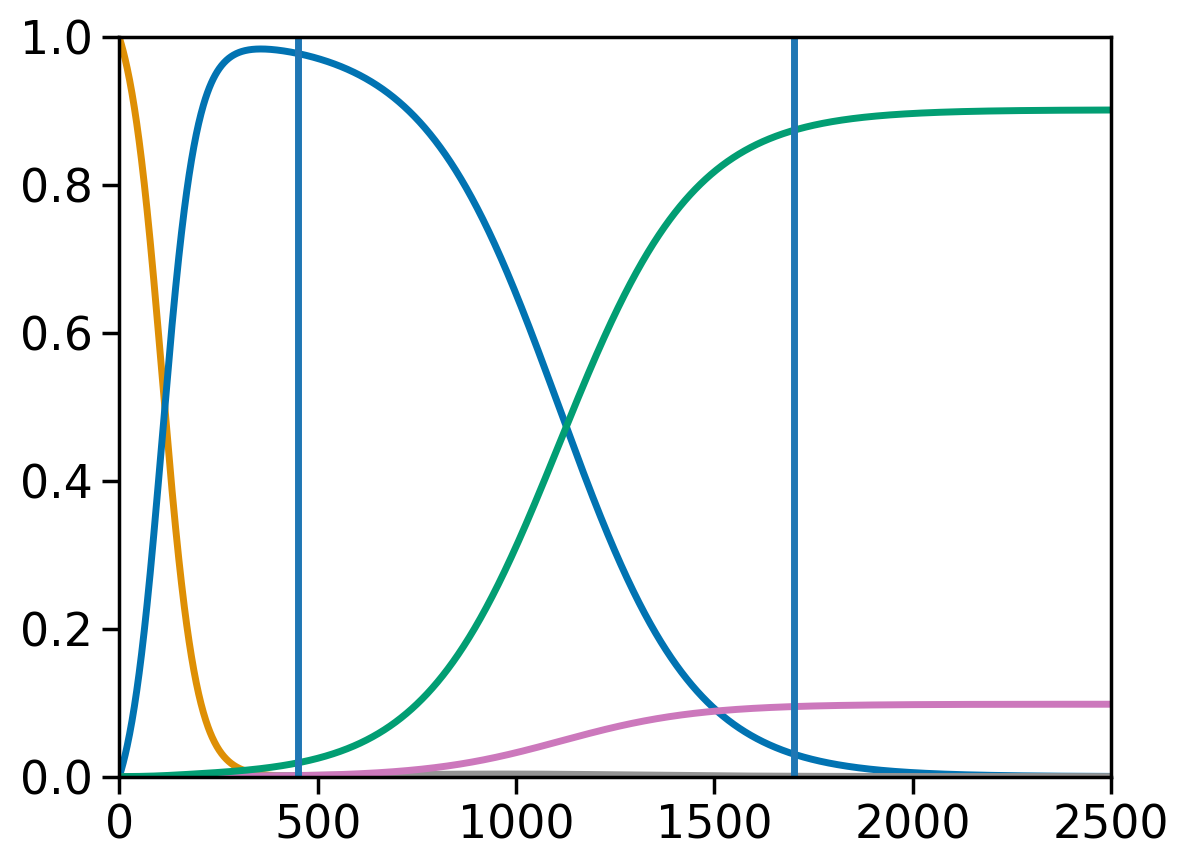

In [52]:
for pi, c in zip(p.T, genotype_colors):
    plt.plot(range(tmax), pi, color=c)
plt.ylim(0, 1)
plt.xlim(0, tmax)
# plt.axhline(0.5, ls='--')
plt.axvline(450);
plt.axvline(1700);

F_A: 0.09792203735027313


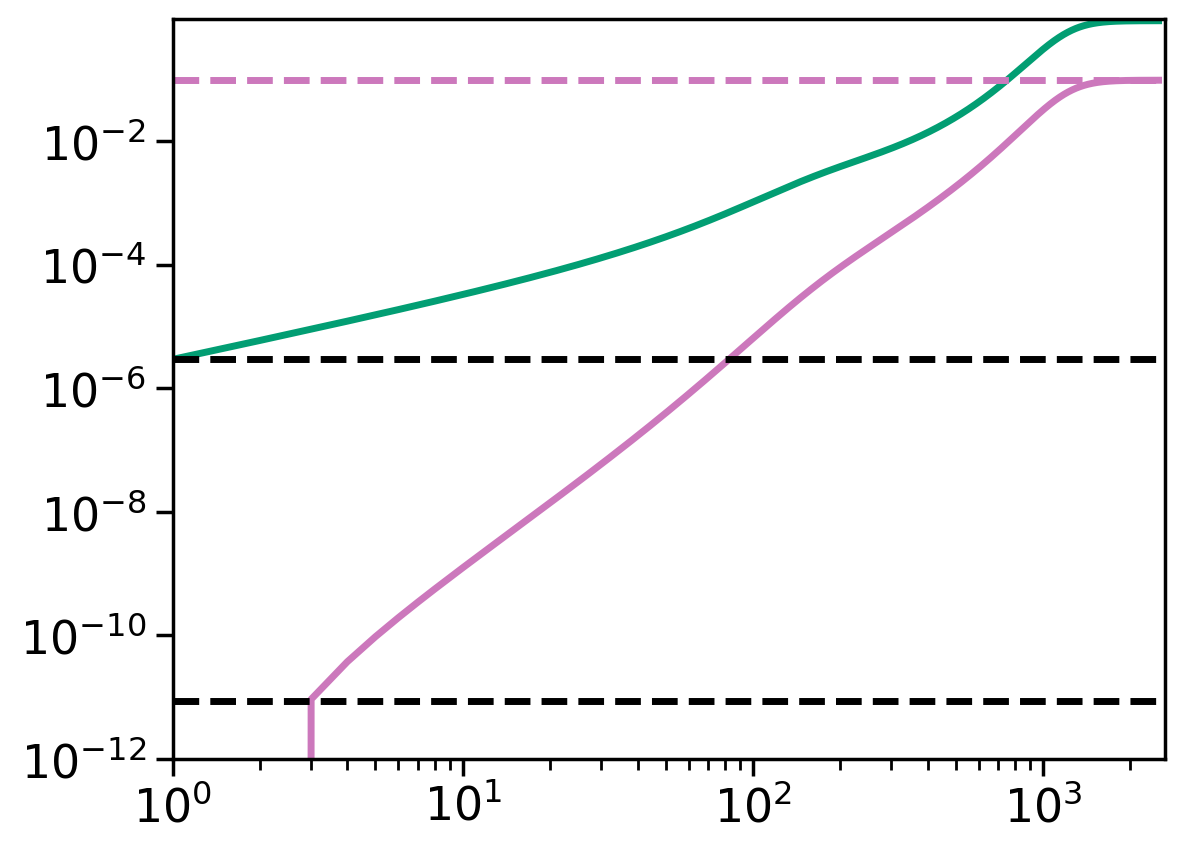

In [53]:
plt.plot(range(tmax), p[:,3], color=genotype_colors[3])
plt.plot(range(tmax), p[:,4], color=genotype_colors[4])
plt.axhline(p[-1, 3], ls='--', color=genotype_colors[3])
print('F_A:', p[-1, 3])

plt.ylim(1e-12,None)
plt.axhline(μ, ls='--', color='k')
plt.axhline(δ*μ*δ, ls='--', color='k')
plt.xlim(1, None)
plt.xscale('log');
plt.yscale('log');

In [22]:
# def simTP(μ, δ, w1, w2, w3, repetition=50, max_gen=5e6, seed=10, fixation=0.999):
#     return modelext.run_simulations(
#         6.425e6, μ, δ, δ,
#          w1, w2, w3, 
#         repetitions=repetition, max_gen=5e4 ,seed=seed, clonal_intf=True, fixation=fixation)

In [23]:
# simMAP = simTP(2.942e-6, 1.722e-3, 1.022, 1.025, 1.028) #simulate the MAP

In [24]:
# np.savez_compressed('../../results/posterior_predictions/simMAP', np.array(simMAP, dtype=object), allow_pickle=True)

In [25]:
simMAP = np.load('../../results/posterior_predictions/simMAP.npz', allow_pickle=True)['arr_0']
simMAP_totalfix = np.array(simMAP[1])
totalfix_MAP = simMAP_totalfix[:,-1,:]+simMAP_totalfix[:,-2,:]
simMAP_2nstar = np.array([np.vstack((simMAP_totalfix[x],totalfix_MAP[x]))for x in range(len(totalfix_MAP))])
np.shape(simMAP_2nstar),np.shape(simMAP_totalfix)

((2398, 6, 50), (2398, 5, 50))

In [26]:
simMAP_totalfix[:,1,:].max(axis=0).min(), simMAP_totalfix[:,2,:].max(axis=0).max() #highest frequency of 2n+1, highest frequency of 2n+1*

(0.980132607003891, 0.004782256809338521)

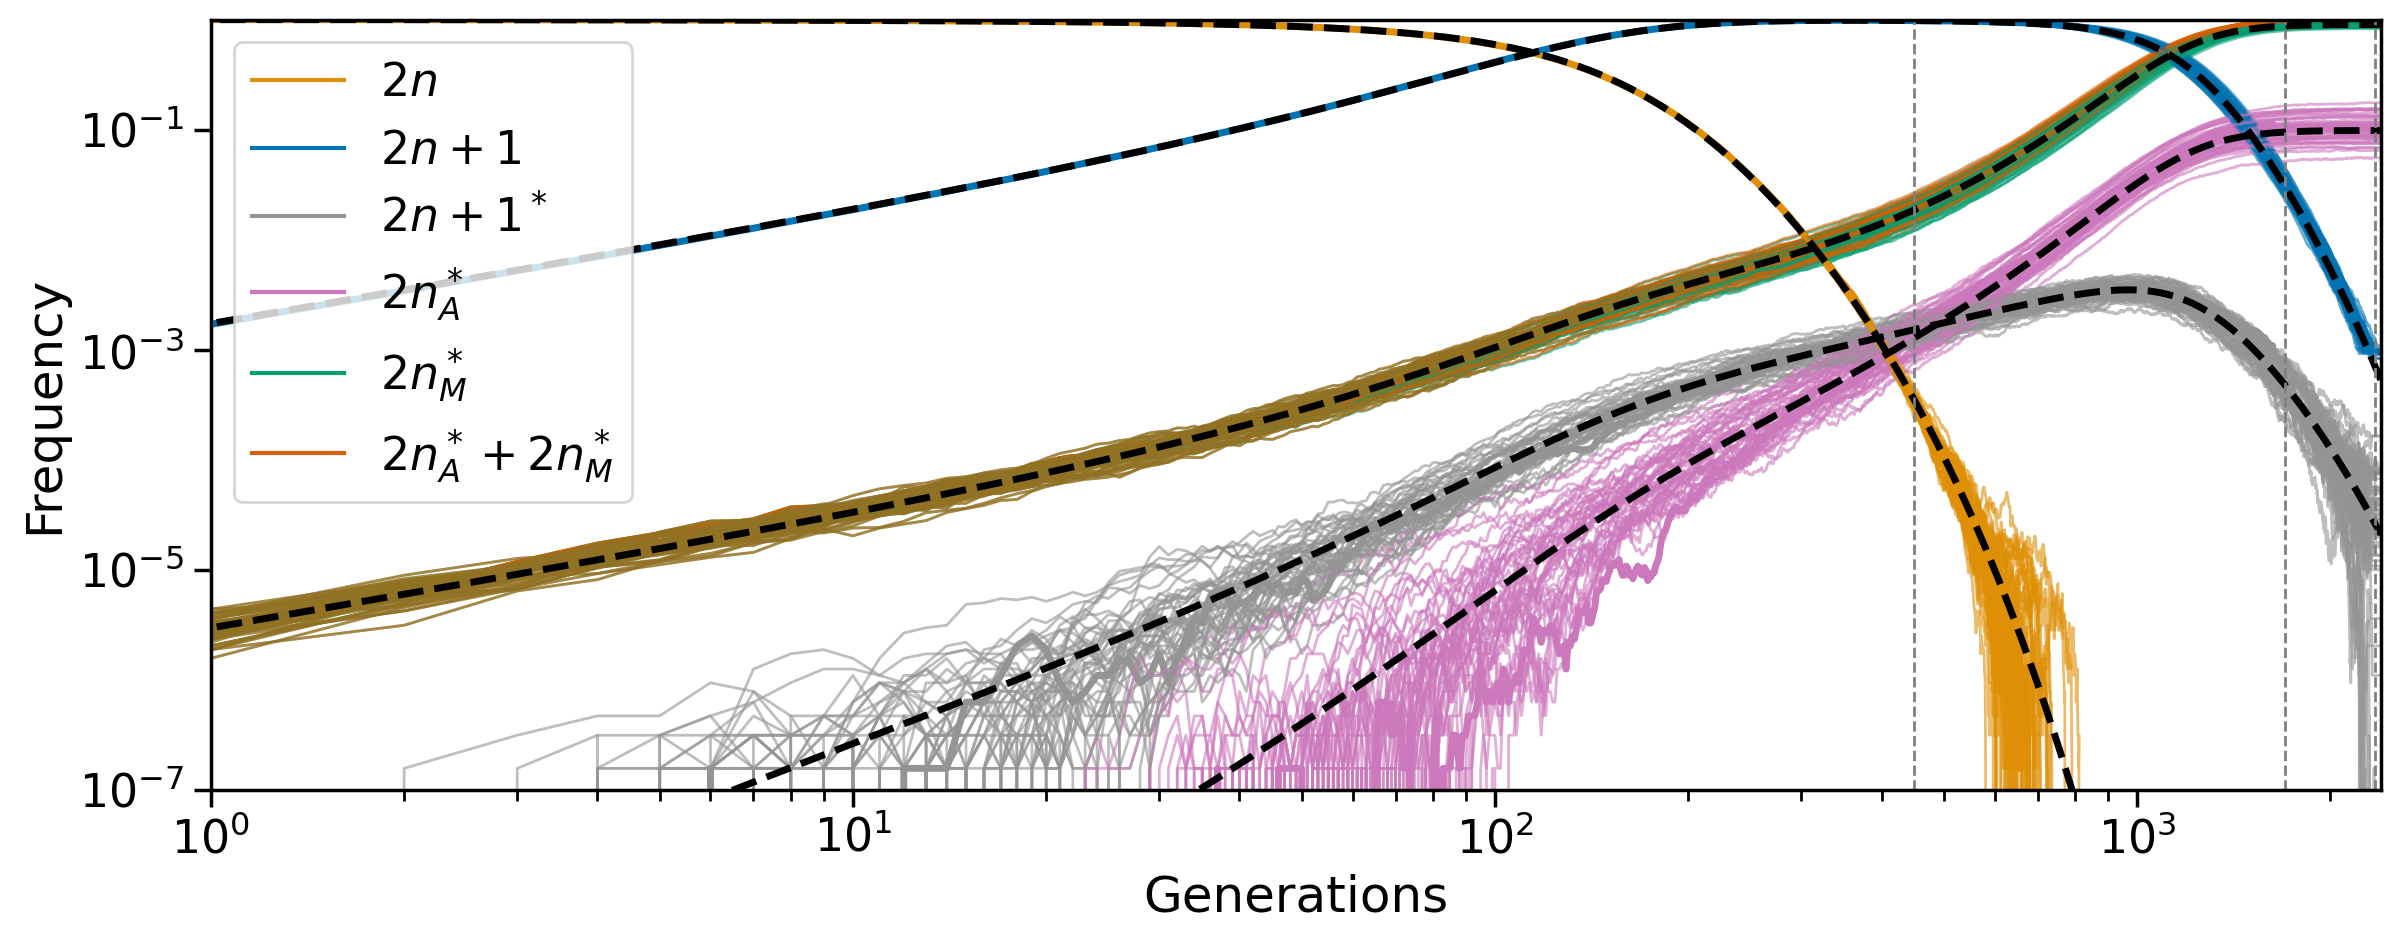

In [58]:
line_kws = dict(linestyle='--', linewidth=1, color='grey')
plot_kws = dict(fixation=0.9999, alpha=.6, xlim=(0, len(totalfix_MAP)), lw=1)

ax = modelext.plot_progress(
    simMAP_2nstar, 
    0, 
    genotype_labels, 
    genotype_colors,
    legend=True
)
for x in range(50):
    modelext.plot_progress(
        simMAP_2nstar, x, 
        genotype_labels, 
        genotype_colors,
        legend=False,
        ax=ax,
        **plot_kws
    ) 
ax.plot(range(tmax), p, 'k', ls='--');
xlabel = ax.set_xlabel("Generations")
ax.axvline(450, **line_kws)
ax.axvline(1700, **line_kws)
ax.axvline(2350, **line_kws)
ax.set_xticks([450, 1700, 2350])
# panel_label = ax.text(-.07, 1.05, 'A', transform=ax.transAxes, **panel_label_kw)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-7, 1)
ax.set_xlim(1, None);

bbox = dict(bbox_inches='tight', bbox_extra_artists=[xlabel])#, panel_label])
ax.figure.savefig('../../figures/MAP_freq_dynamics.pdf', **bbox);

# $F_A$ vs $N$

In [30]:
Nv = np.logspace(4, 8, 75, dtype=int)

In [ ]:
# MAPsim_N = np.array([modelext.run_simulations_time(N, 2.942e-6, 1.722e-3, 1.722e-3, 1.022, 1.025, 1.028, repetitions=250, 
#                    max_gen=5e6, seed=10, fixation=0.999, clonal_intf=True,  fix_frequ=True) for N in Nv], dtype=object)

In [17]:
# np.save('../../results/posterior_predictions/MAPsim_N',  MAPsim_N,  allow_pickle=True)

In [31]:
MAPsim_N = np.load('../../results/posterior_predictions/MAPsim_N.npy', allow_pickle=True)

In [32]:
mean_MAP_N = np.array([np.mean(MAPsim_N[x,2][0][0]) for x in range(len(MAPsim_N))]) # 

In [33]:
n = 10000
bs = np.array([
    [
        np.random.choice(MAPsim_N[x,2][0][0], MAPsim_N[x,2][0][0].size) 
        for i in range(n)
    ] 
    for x in range(len(MAPsim_N)) 
])
bs.shape

(75, 10000, 250)

In [34]:
bs_mean = np.mean(bs, axis=2)
bs_mean.shape

(75, 10000)

In [35]:
perc_MAP_N = np.percentile(bs_mean, (2.5,97.5), axis=1)
perc_MAP_N.shape

(2, 75)

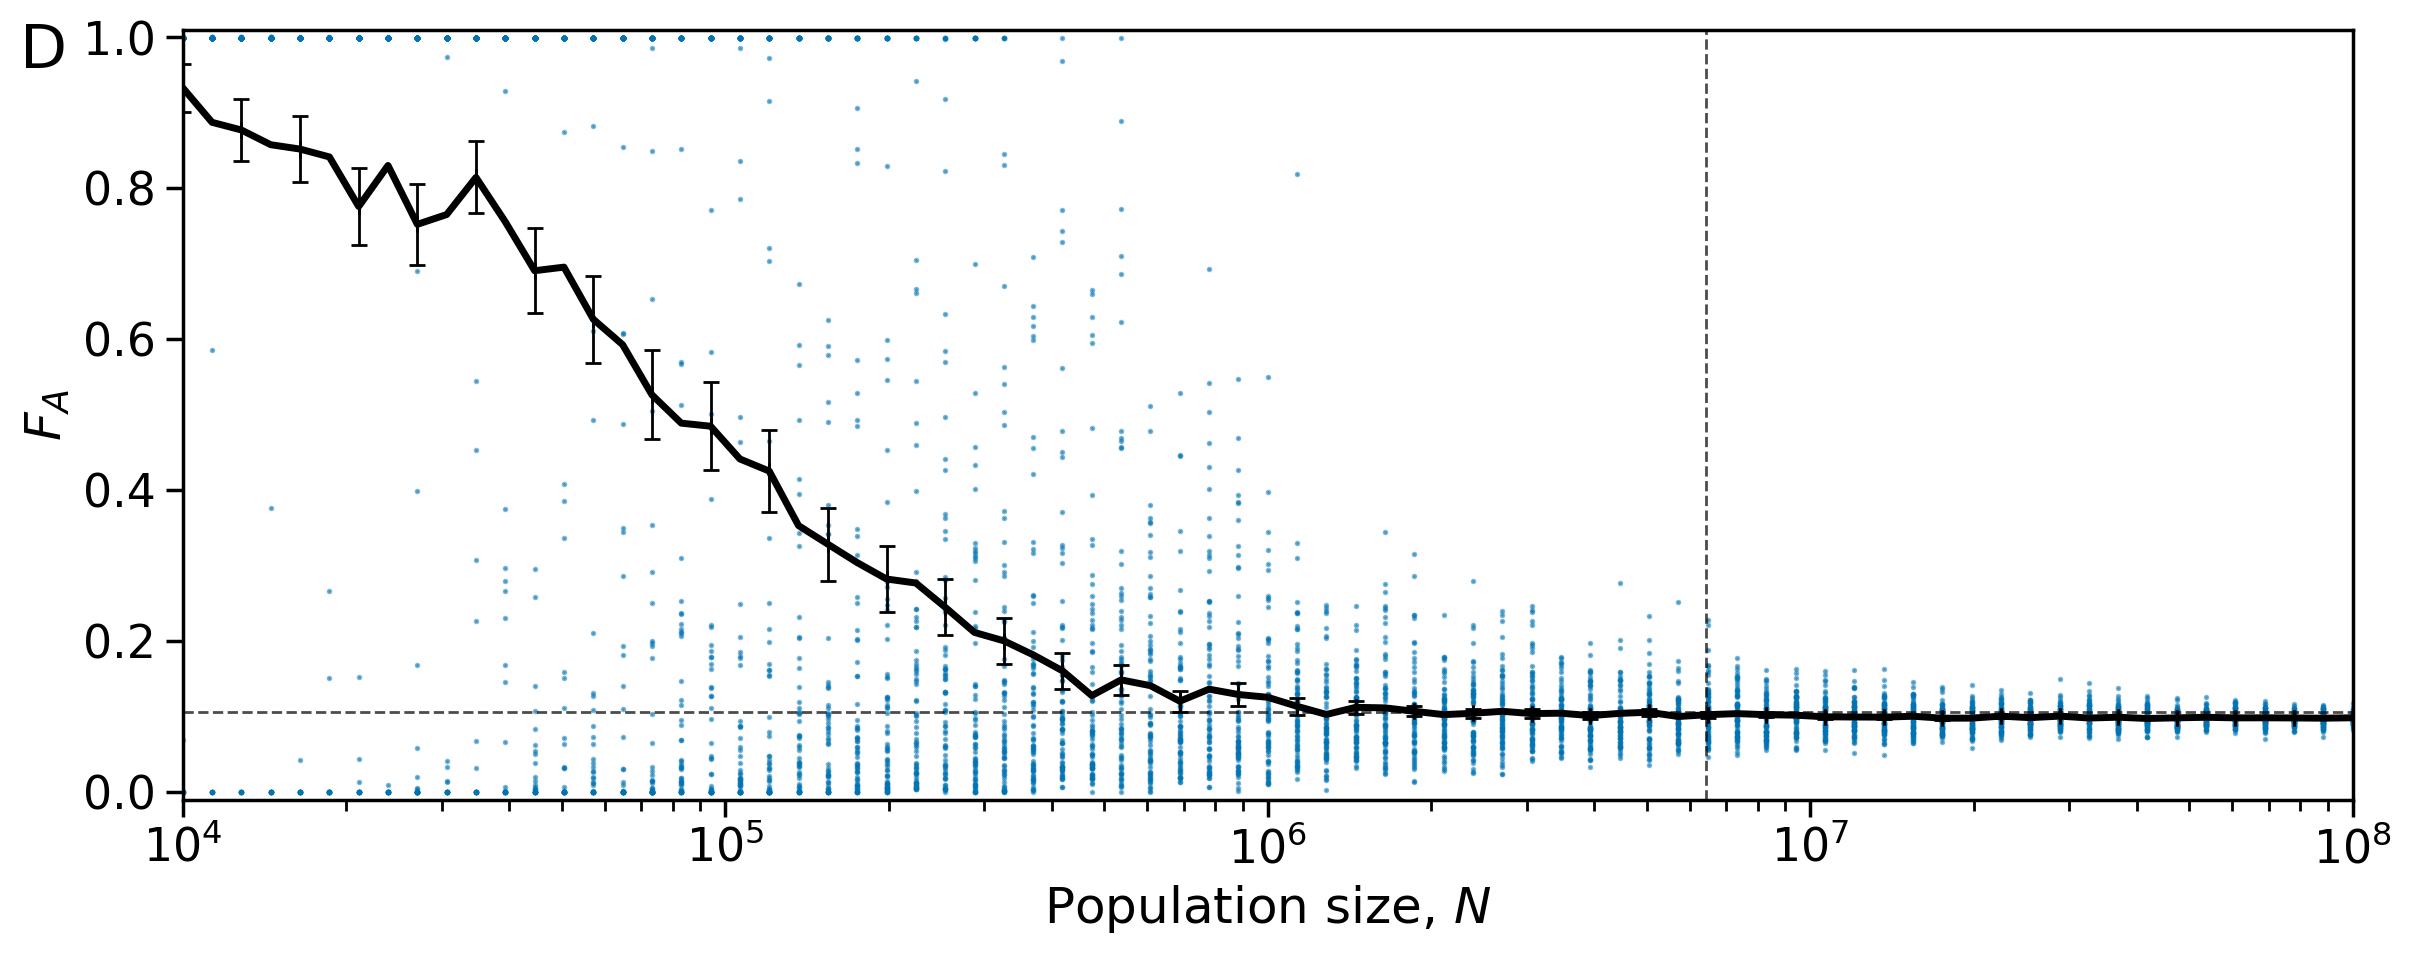

In [36]:
line_kws = dict(color='k', ls='--', lw=1, alpha=0.7)

fig, ax = plt.subplots(figsize=(14,5))

X = np.array([MAPsim_N[x,2][0][0] for x in range(len(MAPsim_N))])
for i in range(X.shape[0]):
    ax.scatter(Nv, X[:,i], color=blue, s=1, alpha=0.5)

ax.errorbar(
    Nv, 
    mean_MAP_N, 
    mean_MAP_N - perc_MAP_N[0],
    perc_MAP_N[1] - mean_MAP_N,
    fmt='k', capsize=3, elinewidth=1, errorevery=2)
ax.axvline(6.425e6, **line_kws)
ax.axhline(0.106, **line_kws)

ax.set_xscale('log')
xlabel = ax.set_xlabel('Population size, $N$')
ax.set_xlim(Nv.min(), Nv.max())
ax.set_ylim(-0.01, 1.01)
ax.set_ylabel("$F_A$")
panel_label = ax.text(-0.075, 0.95, 'D', transform=ax.transAxes, **panel_label_kw)
bbox = dict(bbox_inches='tight', bbox_extra_artists=[xlabel, panel_label])
# fig.savefig('../../figures/FA_vs_N.pdf', **bbox)

# All together

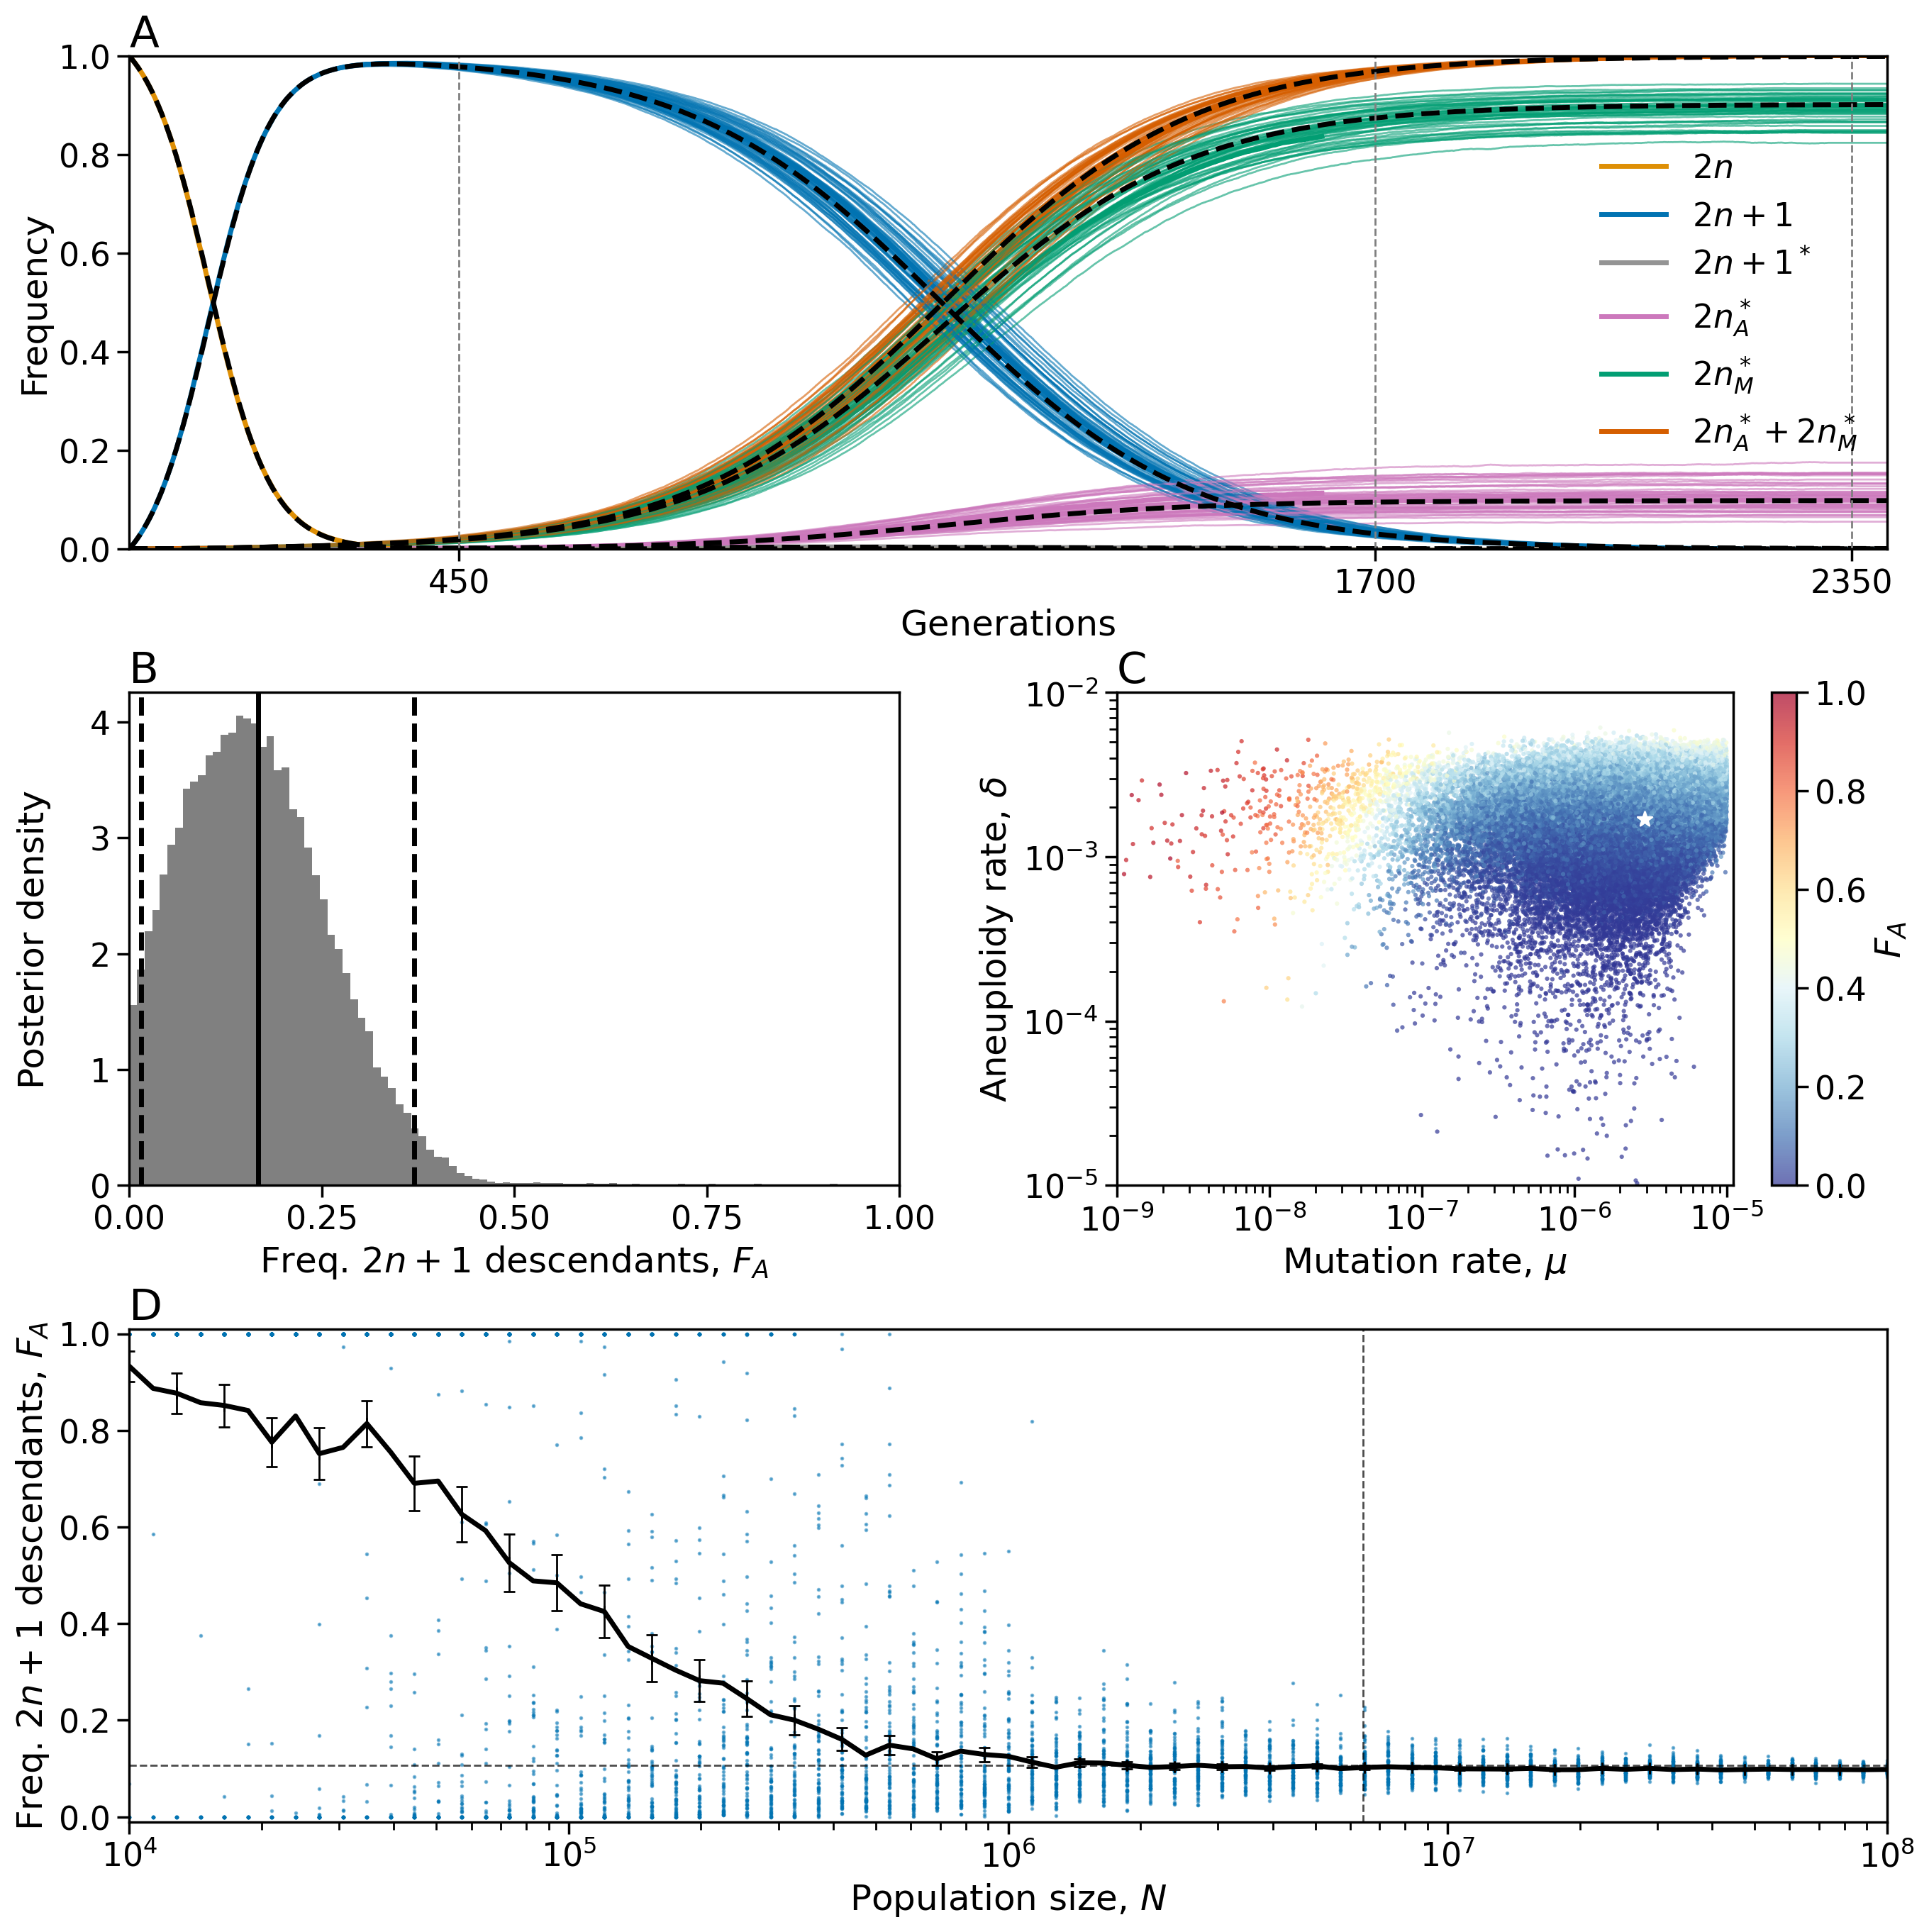

In [56]:
fig, axes = plt.subplot_mosaic((['A','A'], ['B', 'C'], ['D', 'D']), figsize=(14, 14))
FA_label = r'Freq. $2n+1$ descendants, $F_A$'

## A
ax = axes['A']
line_kws = dict(linestyle='--', linewidth=1, color='grey')
plot_kws = dict(fixation=0.9999, alpha=.6, xlim=(0, len(totalfix_MAP)), lw=1)

modelext.plot_progress(
    simMAP_2nstar, 
    0, 
    genotype_labels, 
    genotype_colors,
    legend=True,
    ax=ax
)
for x in range(50):
    modelext.plot_progress(
        simMAP_2nstar, x, 
        genotype_labels, 
        genotype_colors,
        legend=False,
        ax=ax,
        **plot_kws
    ) 
ax.plot(range(tmax), p, 'k', ls='--');
ax.plot(range(tmax), p[:,-2:].sum(axis=1), 'k', ls='--');
ax.set_xlabel("Generations")
ax.axvline(450, **line_kws)
ax.axvline(1700, **line_kws)
ax.axvline(2350, **line_kws)
ax.set_xticks([450, 1700, 2350])
ax.legend(loc='center right', frameon=False)
    
## B 
ax = axes['B']
ax.hist(F_A, 100, density=True,color='grey')
ax.axvline(x=mean_FA,color='k')
ax.axvline(x=perc_FA[0],color='k',ls='--')
ax.axvline(x=perc_FA[1],color='k',ls='--')
ax.set_xlim([0,1])
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_xlabel(FA_label)
ax.set_ylabel('Posterior density')

## C 
ax = axes['C']
im = ax.scatter(post_sam[:,1],post_sam[:,2], c=F_A, cmap="RdYlBu_r", vmin=0, vmax=1, ec=None, alpha=.7, s=5, rasterized=True)
plt.colorbar(im, ax=ax, label='$F_A$')
ax.scatter(2.9e-6,1.7e-3, **star_kw)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Mutation rate, $\mu$')
ax.set_ylabel('Aneuploidy rate, $\delta$')
ax.set_xlim([1e-9,1.1e-5])
ax.set_ylim([1e-5,1e-2])

## D 
ax = axes['D']
line_kws = dict(color='k', ls='--', lw=1, alpha=0.7)

X = np.array([MAPsim_N[x,2][0][0] for x in range(len(MAPsim_N))])
for i in range(X.shape[0]):
    ax.scatter(Nv, X[:,i], color=blue, s=1, alpha=0.5)

ax.errorbar(
    Nv, 
    mean_MAP_N, 
    mean_MAP_N - perc_MAP_N[0],
    perc_MAP_N[1] - mean_MAP_N,
    fmt='k', capsize=3, elinewidth=1, errorevery=2)
ax.axvline(6.425e6, **line_kws)
ax.axhline(0.106, **line_kws)

ax.set_xscale('log')
ax.set_xlabel('Population size, $N$')
ax.set_xlim(Nv.min(), Nv.max())
ax.set_ylim(-0.01, 1.01)
ax.set_ylabel(FA_label)

for k, ax in axes.items():
    ax.text(0, 1.02, k, transform=ax.transAxes, **panel_label_kw)

fig.align_ylabels([axes['A'], axes['B'], axes['D']])
fig.tight_layout(h_pad=0)
fig.savefig('../../figures/FA.pdf')